
# Clasificacion de imagenes satelitales



In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

dir_path = "/content/drive/MyDrive/Proyectos/dataset_TE"
print(dir_path)

/content/drive/MyDrive/Proyectos/dataset_TE


In [110]:
import tensorflow as tf

# Check for GPU availability
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print("GPU is available.")
else:
    print("GPU is NOT available.")

GPU is NOT available.


In [111]:
# Se cargan las imagenes
import os
for dirname, _, filenames in os.walk(dir_path):
  for filename in filenames:
    print(os.path.join(dirname, filename))

Se han truncado las últimas 5000 líneas del flujo de salida.
/content/drive/MyDrive/Proyectos/dataset_TE/cloudy/train_2424.jpg
/content/drive/MyDrive/Proyectos/dataset_TE/cloudy/train_24094.jpg
/content/drive/MyDrive/Proyectos/dataset_TE/cloudy/train_24031.jpg
/content/drive/MyDrive/Proyectos/dataset_TE/cloudy/train_24080.jpg
/content/drive/MyDrive/Proyectos/dataset_TE/cloudy/train_24070.jpg
/content/drive/MyDrive/Proyectos/dataset_TE/cloudy/train_24237.jpg
/content/drive/MyDrive/Proyectos/dataset_TE/cloudy/train_24212.jpg
/content/drive/MyDrive/Proyectos/dataset_TE/cloudy/train_24114.jpg
/content/drive/MyDrive/Proyectos/dataset_TE/cloudy/train_24001.jpg
/content/drive/MyDrive/Proyectos/dataset_TE/cloudy/train_24013.jpg
/content/drive/MyDrive/Proyectos/dataset_TE/cloudy/train_23884.jpg
/content/drive/MyDrive/Proyectos/dataset_TE/cloudy/train_23806.jpg
/content/drive/MyDrive/Proyectos/dataset_TE/cloudy/train_2396.jpg
/content/drive/MyDrive/Proyectos/dataset_TE/cloudy/train_23805.jpg
/co

Preprocesamiento

In [112]:
# Se declaran arrays para almacenar las imagenes y etiquetas
images=[]
labels=[]
train_path =  os.listdir('/content/drive/MyDrive/Proyectos/dataset_TE')
for cdir in train_path:
  folder = os.listdir('/content/drive/MyDrive/Proyectos/dataset_TE/' + cdir)
  for imagen in folder:
    url = '/content/drive/MyDrive/Proyectos/dataset_TE/' + cdir + '/' + imagen
    img = cv2.imread(url)
    arr = Image.fromarray(img, 'RGB')
    img_arr = arr.resize((128, 128))
    labels.append(cdir) # El nombre de la carpeta se convierte en la etiqueta correspondiente
    images.append(np.array(img_arr)) # La imagen se convierte en un arreglo NumPy

In [113]:
# Se codifican numericamente las etiquetas (0-3)
lb_encod = LabelEncoder()
labels = pd.DataFrame(labels)
labels = lb_encod.fit_transform(labels[0])
labels

array([0, 0, 0, ..., 2, 2, 2])

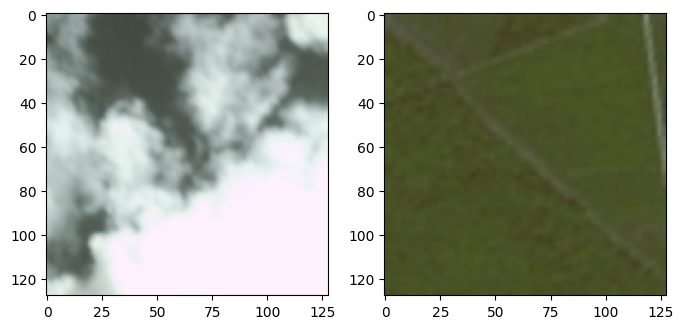

In [114]:
# Cómo se ven un par de imagenes ya procesadas
figure = plt.figure(figsize = (8, 8))
ax = figure.add_subplot(121)
ax.imshow(images[0])
bx = figure.add_subplot(122)
bx.imshow(images[4232])
plt.show()

In [115]:
images = np.array(images)

# Se estadarizan las imagenes
scaler = StandardScaler()
images = scaler.fit_transform(images.reshape(-1, images.shape[-1])).reshape(images.shape)

# Se almacenan imagenes y etiquetas
np.save("image", images)
np.save("labels", labels)
image = np.load("image.npy", allow_pickle = True)
labels = np.load("labels.npy", allow_pickle = True)

# Se randomizan las imagenes para mejorar el entrenamiento
img_shape = np.arange(image.shape[0])
np.random.shuffle(img_shape)
image = image[img_shape]
labels = labels[img_shape]

In [123]:
# Se contabilizan las etiquetas (4) y las imagenes (5631)
n_cats = len(np.unique(labels))
n_imgs = len(image)

# Se divide el dataset en un conjunto de entrenamiento y otro pruebas
x_train, x_test = image[(int)(0.1*n_imgs):], image[:(int)(0.1*n_imgs)]
y_train, y_test = labels[(int)(0.1*n_imgs):], labels[:(int)(0.1*n_imgs)]

# Se convierten las etiquetas a formato categorico
y_train = keras.utils.to_categorical(y_train, n_cats)
y_test = keras.utils.to_categorical(y_test, n_cats)